### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader, data_generation
from helpers import helpers, plotter, metrics, masks
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time

Using TensorFlow backend.


In [4]:
# options: rbf, periodic
print('Kernel? rbf/periodic/rbf_2D')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
save_dir = '/Users/omernivron/Downloads/GPT_' + kernel

Kernel? rbf/periodic/rbf_2D


KeyboardInterrupt: 

In [3]:
data = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise = True, d = True)

['em_te_2.npy', 'pad_pos_tr.npy', 'pad_pos_te.npy', 'em_te.npy', 'em_tr.npy', 'pad_y_fren_tr.npy', 'pad_y_fren_te.npy', 'em_tr_2.npy']


In [5]:
d = True

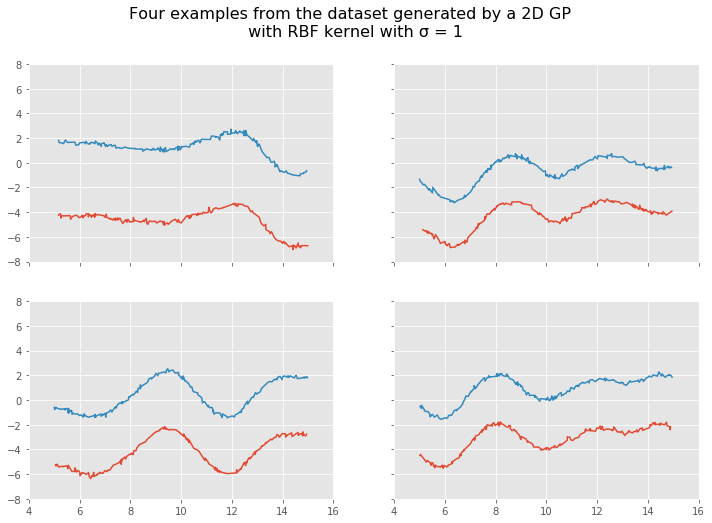

In [6]:
if d:
    plotter.plot_2d_examples(data[1], data[-3], data[-1])
else:
    plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [7]:
### 10.67839196 --> 113
# (pad_pos_tr[12, :])[150]
# em_tr[12, :][150]

In [8]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [9]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)

In [10]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 1; step = 0; train_steps = 35000; heads = 32; ℯ = 512
    l = [256, 256, 64, 32]
    name_comp = 'run_' + str(run) 
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp; 
#     lr_fn = tf.optimizers.schedules.PolynomialDecay(9e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    ℯ, l1, _, l2, l3 = helpers.load_spec(folder, ℯ, l, d = d); 
    helpers.mkdir(folder)
    if d:
        decoder = experimental2d_model.Decoder(ℯ, l1, l2, l3, num_heads = heads)
    else:
        decoder = experimental_model.Decoder(ℯ, l1, l2, l3, num_heads = heads); 
    tf.random.set_seed(443)  
    num_batches = int(data[5].shape[0] / batch_s) if d else int(data[4].shape[0] / batch_s)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
#     optimizer_c = tf.keras.optimizers.Adam(3e-4)
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    b_data = batch_creator.create_batch_gp_mim_2(data[-4], data[1], data[-3], batch_s=64, d = True, em_2 = data[-1])
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True,  pos2 = b_data[3])
                else:
                    b_data = batch_creator.create_batch_gp_mim_2(data[3], data[0], data[4], batch_s=64)
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0])


                if ((epoch == 0) & (batch_n == 0)): helpers.write_speci(folder, names, shapes)
                if batch_n % 300 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, data[3][:500, :], data[5][:500, :], d = True, pos2_te = data[0][:500, :])
                        plotter.follow_training_plot2d(b_data[1], b_data[0], b_data[3] , pred, data[2][:500], data[-2][:500], data[0][:500] ,pred_te, 50)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, data[2][:500, :], data[5][:500, :])
                        plotter.follow_training_plot(b_data[2], b_data[0], pred, data[1][:500, :], data[5][:500, :], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    print('r squared training: ', metrics.r_squared(m_tr.result(), b_data[0][:, 51:]))
                    if d:
                        print('r squared testing: ', metrics.r_squared(m_te.result(), data[5][:500, 51:], batch_s = 500))
                    else: 
                        print('r squared testing: ', metrics.r_squared(m_te.result(), data[4][:500, 51:], batch_s = 500))


                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Already exists
Restored from /Users/omernivron/Downloads/GPT_rbf_2D/ckpt/check_run_1/ckpt-4
Tensor("decoder/multi_head_attention2d/strided_slice:0", shape=(), dtype=int32)
Tensor("decoder/multi_head_attention2d/strided_slice:0", shape=(), dtype=int32)


KeyboardInterrupt: 

In [11]:
# if d:
#     idx = int(7)
#     y = data[5][:500, :]
#     em_te = data[3][:500, :]
#     em_te_2 = data[0][:500, :]
#     cond1 = np.where([em_te_2[idx, 50:] == series])[1]
#     cond2 = np.where(~ (em_te_2[idx, 50:] == series))
#     new_tar = np.concatenate((y[idx, :50], y[idx, 50:][cond1])).reshape(1, -1)

#     new_em = np.concatenate((em_te[idx, :50], (em_te[idx, 50:][cond1])))
#     new_em = np.concatenate((new_em, em_te[idx, 50:][cond2])).reshape(1, -1)


#     new_em_2 = np.concatenate((em_te[idx, :50], (em_te_2[idx, 50:][cond])))
#     new_em_2 = np.concatenate((new_em_2, em_te_2[idx, 50:][cond2])).reshape(1, -1)


#     a = inference(decoder, new_em, new_tar, num_steps=10, sample=True, d = True, em_te_2 = new_em_2, series = 1)
# else:
    
#plotter.infer_plot(decoder, em_te, pad_pos_te, pad_y_fren_te, 150, np.array([7931]), samples = 10)